In [1]:
import pandas as pd
import os
import json
from PIL import Image, ImageDraw
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from skimage.draw import polygon as draw_polygon

In [2]:
wsi_meta = pd.read_csv('wsi_meta.csv')
wsi_meta

,source_wsi,age,sex,race,height,weight,bmi
0,1,58,F,W,160.0,59.0,23.0
1,2,56,F,W,175.2,139.6,45.5
2,3,73,F,W,162.3,87.5,33.2
3,4,53,M,B,166.0,73.0,26.5


In [3]:
train_images_path = 'train/'
test_images_path = 'test/'

train_images = [os.path.splitext(filename)[0] for filename in os.listdir(train_images_path)]
test_images = [os.path.splitext(filename)[0] for filename in os.listdir(test_images_path)]

In [7]:
polygons_data = load_jsonl_data('polygons.jsonl')

In [4]:
def load_jsonl_data(filepath):
    data = []
    with open(filepath, 'r') as file:
        for line in file:
            data.append(json.loads(line))
    return data

In [5]:
def determine_image_set(image_id):
    if image_id in train_images:
        return 'train'
    elif image_id in test_images:
        return 'test'
    return None

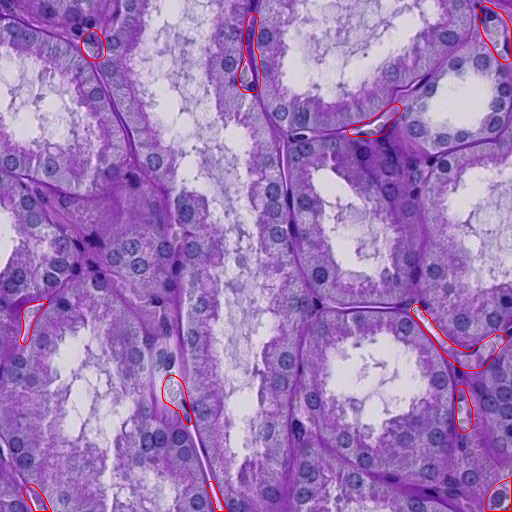

In [8]:
#przykład
selected_image_id = '312bb1ba445f'
image_set = determine_image_set(selected_image_id)

if image_set == 'train':
    image_path = os.path.join(train_images_path, selected_image_id + '.tif')

    with Image.open(image_path) as img:
        draw = ImageDraw.Draw(img)
        for polygon in polygons_data:
            if polygon['id'] == selected_image_id:
                for annotation in polygon['annotations']:
                    coordinates = [(point[0], point[1]) for point in annotation['coordinates'][0]]
                    if annotation['type'] == 'blood_vessel':
                        draw.polygon(coordinates, outline='red')
                    elif annotation['type'] == 'glomerulus':
                        draw.polygon(coordinates, outline='green')
                    elif annotation['type'] == 'unsure':
                        draw.polygon(coordinates, outline='yellow')
        display(img)

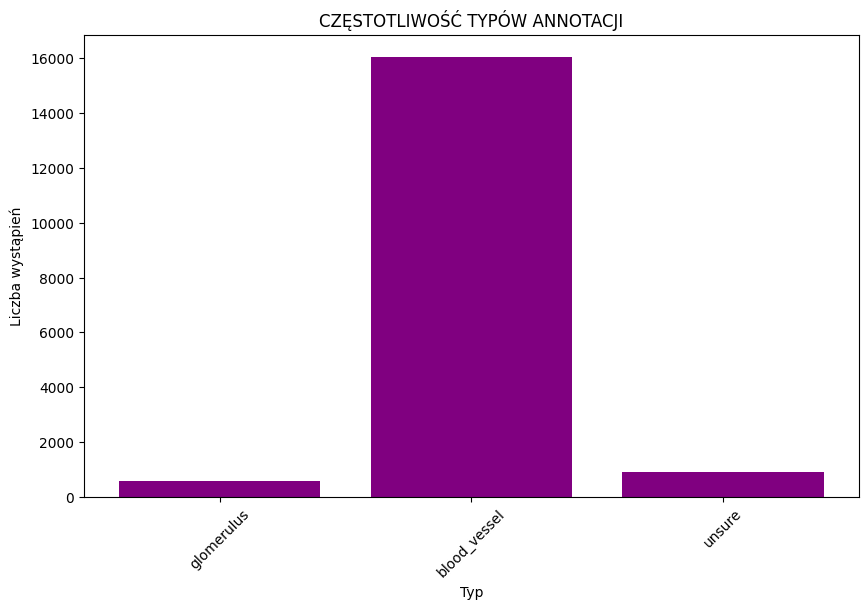

In [9]:
types = [annotation['type'] for polygon in polygons_data for annotation in polygon['annotations']]
types_count = Counter(types)

plt.figure(figsize=(10, 6))
plt.bar(types_count.keys(), types_count.values(), color='purple')
plt.title('CZĘSTOTLIWOŚĆ TYPÓW ANNOTACJI')
plt.xlabel('Typ')
plt.ylabel('Liczba wystąpień')
plt.xticks(rotation=45)
plt.show()

In [10]:
num_images = len(polygons_data)
annotations_per_image = np.mean([len(polygon['annotations']) for polygon in polygons_data])

print(f'Liczba obrazów: {num_images}')
print(f'Średnia liczba annotacji na obraz: {annotations_per_image:.2f}')

Liczba obrazów: 1633
Średnia liczba annotacji na obraz: 10.73


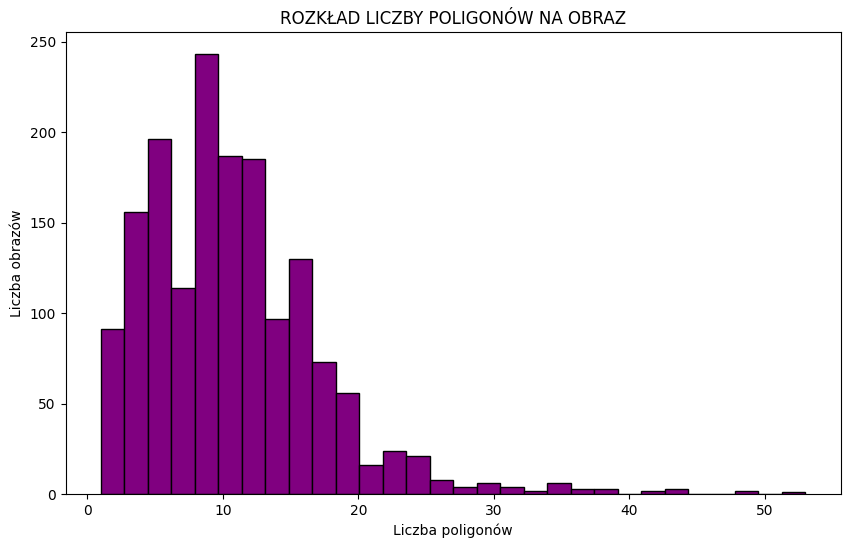

In [11]:
annotations_count = [len(polygon['annotations']) for polygon in polygons_data]

plt.figure(figsize=(10, 6))
plt.hist(annotations_count, bins=30, color='purple', edgecolor='black')
plt.title('ROZKŁAD LICZBY POLIGONÓW NA OBRAZ')
plt.xlabel('Liczba poligonów')
plt.ylabel('Liczba obrazów')
plt.show()

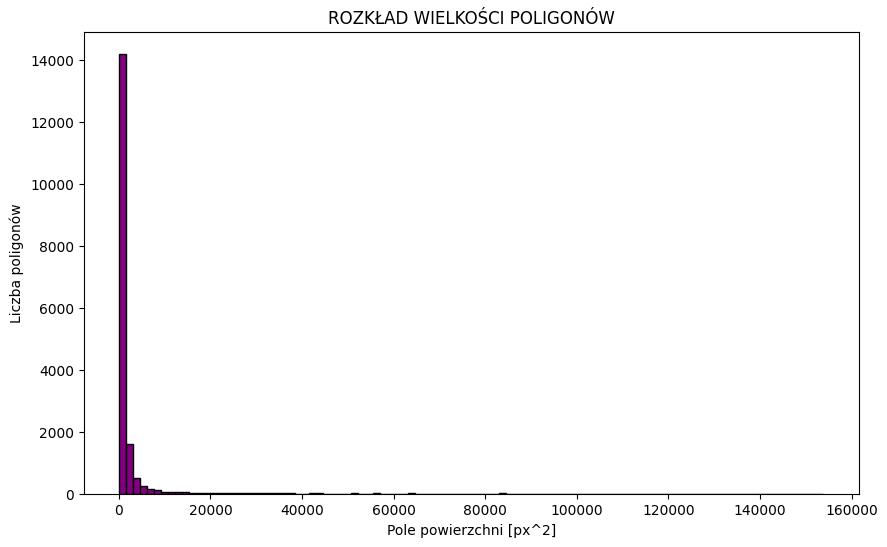

In [12]:
def calculate_polygon_area(coords):
    x = coords[:, 0]
    y = coords[:, 1]
    return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))

areas = []

for polygon in polygons_data:
    for annotation in polygon['annotations']:
        coords = np.array(annotation['coordinates'][0])
        area = calculate_polygon_area(coords)
        areas.append(area)

plt.figure(figsize=(10, 6))
plt.hist(areas, bins=100, color='purple', edgecolor='black')
plt.title('ROZKŁAD WIELKOŚCI POLIGONÓW')
plt.xlabel('Pole powierzchni [px^2]')
plt.ylabel('Liczba poligonów')
plt.show()

In [13]:
area_per_type = defaultdict(list)
for polygon in polygons_data:
    for annotation in polygon['annotations']:
        area = calculate_polygon_area(np.array(annotation['coordinates'][0]))
        area_per_type[annotation['type']].append(area)

stats = []
for annotation_type, areas in area_per_type.items():
    stats.append({
        'Typ': annotation_type,
        'Średnia wielkość': np.round(np.mean(areas),2),
        'Odchylenie standardowe': np.round(np.std(areas),2),
        'Mediana': np.round(np.median(areas),2),
    })

stats_df = pd.DataFrame(stats)
stats_df.sort_values('Typ', inplace=True)
stats_df.reset_index(drop=True, inplace=True)
stats_df

,Typ,Średnia wielkość,Odchylenie standardowe,Mediana
0,blood_vessel,1158.96,3274.22,500.5
1,glomerulus,34668.10,31351.34,26173.5
2,unsure,2224.69,4085.71,1036.0
